# 02. Cross-Validation for Model Evaluation | التحقق المتقاطع لتقييم النماذج

## 📚 Prerequisites (What You Need First) | المتطلبات الأساسية

**BEFORE starting this notebook**, you should have completed:
- ✅ **Unit 1: All examples** - Data processing and basic regression
- ✅ **Unit 2, Example 1: Ridge and Lasso** - Understanding model evaluation
- ✅ **Understanding of train-test split**: Why we split data

**If you haven't completed these**, you might struggle with:
- Understanding why cross-validation is better than simple train-test split
- Knowing when to use K-Fold vs Leave-One-Out
- Understanding how cross-validation helps with model selection

---

## 🔗 Where This Notebook Fits | مكان هذا الدفتر

**This is Unit 2, Example 2** - it improves how we evaluate models!

**Why this example SECOND in Unit 2?**
- **Before** you can properly evaluate models, you need to understand basic evaluation
- **Before** you can select the best model, you need reliable evaluation methods
- **Before** you can tune hyperparameters, you need cross-validation

**Builds on**: 
- 📓 Unit 1, Example 3: Train-Test Split (we know basic splitting)
- 📓 Unit 2, Example 1: Ridge/Lasso (we evaluated models with simple split)

**Leads to**: 
- 📓 Unit 5, Example 1: Grid Search (uses cross-validation for hyperparameter tuning)
- 📓 All ML projects (cross-validation is the gold standard for evaluation!)

**Why this order?**
1. Cross-validation improves **model evaluation** (more reliable than single split)
2. Cross-validation enables **model comparison** (fair comparison between models)
3. Cross-validation is essential for **hyperparameter tuning** (used in grid search)

---

## The Story: Getting Multiple Opinions | القصة: الحصول على آراء متعددة

Imagine you're hiring someone. **Before** cross-validation, you ask one person's opinion (single train-test split) - might be biased! **After** cross-validation, you ask multiple people (multiple folds) and average their opinions - much more reliable!

Same with machine learning: **Before** cross-validation, we evaluate on one test set (might be lucky/unlucky). **After** cross-validation, we evaluate on multiple test sets and average - much more reliable!

---

## Why Cross-Validation Matters | لماذا يهم التحقق المتقاطع؟

Cross-validation is the gold standard for model evaluation:
- **More Reliable**: Uses all data for both training and testing (in different folds)
- **Less Variance**: Averages results across multiple folds
- **Better Model Selection**: Fairly compares different models
- **Detects Overfitting**: Shows if model performance varies across folds
- **Industry Standard**: Used in all professional ML projects

## Learning Objectives | أهداف التعلم
1. Implement K-Fold Cross-Validation
2. Use cross-validation for model comparison
3. Understand Leave-One-Out Cross-Validation (LOOCV)
4. Compare models using cross-validation scores
5. Visualize cross-validation splits and results
6. Know when to use each cross-validation method

In [83]:
# Step 1: Import necessary libraries
# These libraries help us perform cross-validation

import pandas as pd  # For data manipulation
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For visualizations
from sklearn.model_selection import (
    KFold,              # K-Fold cross-validation (splits data into K folds)
    StratifiedKFold,    # Stratified K-Fold (maintains class distribution)
    LeaveOneOut,        # Leave-One-Out CV (each sample is a fold)
    cross_val_score,    # Computes cross-validation scores
    cross_validate,     # Computes multiple metrics with CV
    train_test_split    # Simple train-test split (for comparison)
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # Models to evaluate
from sklearn.preprocessing import StandardScaler  # For scaling features
from sklearn.metrics import mean_squared_error, r2_score, make_scorer  # Evaluation metrics

print("✅ Libraries imported successfully!")
print("\n📚 What each cross-validation tool does:")
print("   - KFold: Splits data into K equal folds")
print("   - cross_val_score: Computes scores for each fold")
print("   - cross_validate: Computes multiple metrics at once")
print("   - LeaveOneOut: Each sample is its own test set (expensive but thorough)")

✅ Libraries imported successfully!

📚 What each cross-validation tool does:
   - KFold: Splits data into K equal folds
   - cross_val_score: Computes scores for each fold
   - cross_validate: Computes multiple metrics at once
   - LeaveOneOut: Each sample is its own test set (expensive but thorough)


## 🤔 Why Cross-Validation? Why Not Just Use MSE? | لماذا التحقق المتقاطع؟ لماذا لا نستخدم MSE فقط؟

**This is the MOST IMPORTANT question to understand!** Before we learn HOW to do cross-validation, let's understand WHY we need it.

### 🏠 Why Cross-Validation Matters for Housing Price Prediction

**Real Problem with California Housing Data:**
- Housing prices vary dramatically by region (coastal vs inland, urban vs rural)
- Single split might have mostly expensive houses (San Francisco area) → MSE looks high
- Single split might have mostly cheap houses (rural areas) → MSE looks low
- **You don't know if your model is good or just lucky with the split!**

**Solution:** Cross-validation tests on different regions (different folds) → average performance across all regions → reliable estimate!

---

### ❌ The Problem with Just Using MSE (or Any Single Metric) on One Test Set

Imagine you evaluate your model with just one metric on one test set. What could go wrong?

#### Problem 1: **Lucky or Unlucky Split** 🎲
- **Issue:** Single split might have "easy" or "hard" examples by chance
- **Housing Example:** 
  - Split 1: Test set has mostly predictable houses → MSE = 0.50 (looks great!)
  - Split 2: Test set has mostly unpredictable houses → MSE = 0.57 (looks bad!)
  - **Which one is the "real" performance?** 🤷
- **Generic Example:** Split 1: MSE = 50 (lucky), Split 2: MSE = 150 (unlucky) → Which is real?
- **Solution:** Cross-validation tests on MULTIPLE splits → average = reliable estimate!

#### Problem 2: **Overfitting to One Test Set** 🎯
- **Issue:** Model might perform well on one specific test set but fail on others
- **Example:** Model A: MSE = 100 (Test 1), MSE = 95 (Test 2) → Avg = 97.5
- **Example:** Model B: MSE = 90 (Test 1), MSE = 110 (Test 2) → Avg = 100
- **Problem:** Single split makes Model B look better, but Model A is actually better!
- **Solution:** Cross-validation evaluates on MULTIPLE test sets → fair comparison!

#### Problem 3: **High Variance in Evaluation** 📊
- **Issue:** Single split = ONE evaluation with unknown reliability
- **Example:** Single split: MSE = 100 (but is it really 100? or 80? or 120?)
- **Solution:** Cross-validation: MSE = 100 ± 20 → you know the range [80-120]!

#### Problem 4: **Wasting Data** 📉
- **Issue:** Simple split uses 80% train, 20% test → test set only used once
- **Example:** 1000 samples → 800 train, 200 test (test discarded after one evaluation)
- **Solution:** Cross-validation uses ALL data for both training AND testing (in different folds)

---

### ✅ Why Cross-Validation Solves These Problems

**Cross-validation systematically addresses all four problems:**

1. **Multiple Evaluations = Reliable Average** 📈
   - Split data into 5 folds, evaluate 5 times, average the scores
   - Example: Folds give MSE = [50, 150, 100, 120, 80] → Mean = 100, Std = 35
   - No more "lucky" or "unlucky" single splits!

2. **Fair Model Comparison** ⚖️
   - All models tested on EXACTLY the same test sets
   - No bias from specific test set → fair comparison guaranteed!

3. **Confidence Intervals** 📊
   - Mean ± Std shows range of performance
   - Not just one number, but a range you can trust!

4. **Efficient Data Usage** 💯
   - All samples used for training (in different folds)
   - All samples used for testing (in different folds)
   - 100% data usage vs 80% in simple split!

---

### 🎯 Key Insight: MSE is NOT the Problem!

**Important:** MSE (or R², or any metric) is NOT the problem!

**The problem is:** Using MSE on a SINGLE test set gives unreliable results!

**The solution:** Use MSE (or any metric) on MULTIPLE test sets (cross-validation) → reliable results!

---

### 📊 Comparison: Single Split vs Cross-Validation

| Aspect | Single Train-Test Split | Cross-Validation |
|--------|-------------------------|------------------|
| **Number of Evaluations** | 1 | K (typically 5 or 10) |
| **Reliability** | Low (one evaluation) | High (multiple evaluations) |
| **Variance** | Unknown | Known (std across folds) |
| **Data Usage** | 80% train, 20% test | 100% used for both |
| **Model Comparison** | Unfair (different test sets) | Fair (same test sets) |
| **Confidence** | Low (one number) | High (mean ± std) |
| **Overfitting Risk** | High (one test set) | Low (multiple test sets) |

---

### 💡 Real-World Analogy

**Single Split = Asking One Person's Opinion**
- You ask one person: "Is this candidate good?" → "Yes!" ✅
- **Problem:** Maybe they're biased or just lucky?
- **Solution:** Ask 5 people and average their opinions → more reliable!

**Cross-Validation = Asking Multiple People's Opinions**
- You ask 5 people: "Is this candidate good?"
- Answers: Yes, No, Yes, Yes, No → Average: 60% positive
- **Much more reliable!** You know the range of opinions!

---

### ✅ Summary: Why Cross-Validation?

1. **More Reliable** ✅ - Multiple evaluations → average is more reliable
2. **Fair Comparison** ✅ - All models tested on same test sets
3. **Confidence Intervals** ✅ - Mean ± Std shows range of performance
4. **Efficient Data Usage** ✅ - All data used for both training and testing
5. **Industry Standard** ✅ - Used in all professional ML projects

---

### ⚠️ Common Misunderstanding: "Small Variance = CV Not Needed"

**Students often think:** "If variance is small, cross-validation doesn't matter"

**But this is WRONG!** Here's why:

**Without CV:**
- You get ONE number (e.g., MSE = 0.56)
- But you DON'T KNOW: Is it really 0.56? Or could it be 0.50? Or 0.57?
- You have NO IDEA about reliability or confidence interval
- You don't know if this single split was typical or extreme

**With CV:**
- You get MEAN ± STD (e.g., MSE = 0.53 ± 0.02)
- You KNOW: True performance is between 0.51 and 0.55 (95% confidence)
- You have a RELIABLE estimate with confidence interval
- You know if your single split was typical or extreme

**Key Insight:** 
- The point isn't that variance is **large** - it's that you **KNOW** the variance!
- Even with small variance, CV tells you the TRUE performance range
- Without CV, you have ONE number with UNKNOWN reliability
- With CV, you have MEAN ± STD with KNOWN reliability

**Example:**
- Single split: "MSE = 0.56" → Is it really 0.56? Or 0.50? Or 0.57? 🤷
- Cross-validation: "MSE = 0.53 ± 0.02" → True performance is 0.51-0.55 ✅

**Note:** We'll demonstrate both small variance (California Housing) and high variance (smaller subset) cases to show why CV matters in both scenarios!

---

### 🎓 Common Student Questions

**Q: Why not just use MSE on training set?**
- **Answer:** Training MSE is biased (model knows the data it was trained on)
- **Solution:** Need test set (unseen data) → Better: Multiple test sets (cross-validation)

**Q: Why not just use a larger test set?**
- **Answer:** Larger test set = less training data → worse model!
- **Solution:** Cross-validation uses ALL data for training AND testing (best of both worlds)

**Q: Why not just use MSE multiple times on different splits?**
- **Answer:** That's EXACTLY what cross-validation does! 🎯
- **Cross-validation = systematic way to use MSE on multiple splits**

**Q: Is MSE the problem?**
- **Answer:** NO! MSE is a great metric!
- **The problem:** Using MSE on a SINGLE test set
- **The solution:** Using MSE on MULTIPLE test sets (cross-validation)

**Q: Is cross-validation always better than simple split?**
- **Answer:** Usually yes, but not always!
- **For very large datasets (>100K samples):** Simple split might be sufficient (single split is reliable enough)
- **For small-medium datasets (<10K samples):** Cross-validation is essential (single split unreliable)
- **For our California Housing (20K samples):** Cross-validation is recommended for reliable evaluation

**Q: Why does cross-validation take longer?**
- **Answer:** Cross-validation trains the model K times (5 times for 5-fold CV)
- **Simple split:** Train once, test once = 1 model training
- **5-fold CV:** Train 5 times, test 5 times = 5 model trainings
- **Trade-off:** More computation time for more reliable evaluation
- **Tip:** Use `n_jobs=-1` parameter to parallelize CV (faster on multi-core machines)

**Q: When should I use cross-validation vs simple split?**
- **Use Cross-Validation when:**
  - Dataset < 10,000 samples (need reliable evaluation)
  - Comparing multiple models (need fair comparison)
  - Tuning hyperparameters (need reliable performance estimate)
  - Limited data (need to use all data efficiently)
- **Use Simple Split when:**
  - Very large dataset (>100K samples, single split reliable enough)
  - Quick baseline evaluation needed
  - Computational constraints (very expensive models)
- **See Decision Framework (Cell 25) for detailed guide!**

**Q: Why do I get different results each time I run cross-validation?**
- **Answer:** Random shuffling creates different folds each time
- **Solution:** Set `random_state` parameter (e.g., `random_state=42`) for reproducible results
- **Example:** `KFold(n_splits=5, shuffle=True, random_state=42)` → same folds every time
- **Note:** Without `random_state`, folds change → results vary slightly (but mean should be similar)

---

### 🚀 Next Steps

Now that you understand **WHY** cross-validation is needed, let's learn **HOW** to do it!

**Remember:** 
- ✅ MSE (or any metric) is fine - use it!
- ✅ The problem is using it on a SINGLE test set
- ✅ The solution is using it on MULTIPLE test sets (cross-validation)
- ✅ Cross-validation makes your evaluation RELIABLE and FAIR!


## 🚀 Quick Start (Optional) | بدء سريع (اختياري)

**Want to jump right in?** Run the code cells below to see cross-validation in action, then come back to read the detailed explanations!

**Quick Path:**
1. Run Cell 4: Load data
2. Run Cell 6: Prepare data
3. Run Cell 8: Simple split (baseline)
4. Run Cell 15: K-Fold CV (main method)
5. Run Cell 17: Compare models

**Full Path:** Read all explanations from the beginning for complete understanding!


In [84]:
# SOLUTION: Load real-world California Housing dataset
# This is REAL data perfect for demonstrating cross-validation with complete solutions!

from sklearn.datasets import fetch_california_housing

print("\n📥 Loading California Housing dataset...")
print("تحميل مجموعة بيانات كاليفورنيا للإسكان...")

housing_data = fetch_california_housing()

# SOLUTION: Create DataFrame from real-world data
df = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
df['target'] = housing_data.target  # Median House Value

print(f"\n✅ Real-world California Housing data loaded!")
print(f"   📊 This is REAL data from the 1990 California census")
print(f"   📈 Contains {len(df)} housing districts with {len(df.columns)-1} features")
print(f"   💰 Target: Median House Value (in $100,000s)")
print(f"\n📄 First 5 rows:")
print(df.head())
print("\n📊 Dataset Info:")
print(f"   Features: {', '.join(housing_data.feature_names[:4])}... and {len(housing_data.feature_names)-4} more")
print(f"   Target range: ${df['target'].min():.2f} - ${df['target'].max():.2f} (in $100,000s)")
print("\n🔍 Notice:")
print("   - This is REAL housing data from 1990 California census")
print("   - 8 features: MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude")
print("   - Perfect for comparing simple train-test split vs cross-validation!")
print("   - Cross-validation will give more reliable evaluation on this real data!")
print("   - Complete solutions provided for every step!")
print("\n💡 Why Cross-Validation Matters for This Dataset:")
print("   - Housing prices vary by region (coastal vs inland, urban vs rural)")
print("   - Single split might have mostly expensive areas → model looks bad")
print("   - Single split might have mostly cheap areas → model looks good")
print("   - Cross-validation tests on different regions → reliable estimate!")
print("   - We'll see this in action: different splits give different scores!")



📥 Loading California Housing dataset...
تحميل مجموعة بيانات كاليفورنيا للإسكان...

✅ Real-world California Housing data loaded!
   📊 This is REAL data from the 1990 California census
   📈 Contains 20640 housing districts with 8 features
   💰 Target: Median House Value (in $100,000s)

📄 First 5 rows:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  

📊 Dataset Info:
   Features: MedInc, HouseAge, AveRooms, AveBedrms... and 4 more
   Target range: $0.1

## Step 1: Prepare Data for Modeling | الخطوة 1: إعداد البيانات للنمذجة

**BEFORE**: We have the California Housing dataset loaded, but we need to extract features (X) and target (y) for modeling.

**AFTER**: We'll extract features and target, then scale them for cross-validation!

**Why this step?** Models need features (X) and target (y) as separate arrays. Scaling ensures fair comparison across features!

In [85]:
# SOLUTION: Prepare features (X) and target (y) from the loaded data
# Extract features and target from DataFrame
X = df[housing_data.feature_names].values  # Features as numpy array
y = df['target'].values  # Target as numpy array

print(f"\n✅ Data prepared for modeling:")
print(f"   Features (X): {X.shape[1]} features")
print(f"   Target (y): {len(y)} samples")
print(f"   Feature names: {', '.join(housing_data.feature_names[:4])}... and more")
print(f"   Feature shape: {X.shape}")
print(f"   Target shape: {y.shape}")

# SOLUTION: Scale features
# IMPORTANT: Regularization and cross-validation require scaled features!
# StandardScaler standardizes features (mean=0, std=1)
scaler = StandardScaler()
# .fit_transform(data)
# - Two operations in one: .fit() then .transform()
#   1. .fit(): Learns parameters from data (mean/std, categories, etc.)
#   2. .transform(): Applies transformation using learned parameters
# - Use on training data
# - For test data, use only .transform() (don't refit!)

X_scaled = scaler.fit_transform(X)
print(f"\n   ✅ Features scaled!")
print(f"   Before scaling - Mean range: [{X.mean(axis=0).min():.2f}, {X.mean(axis=0).max():.2f}]")
print(f"   After scaling - Mean: {X_scaled.mean(axis=0).round(2)[:3]}... (all ≈0)")
print(f"   After scaling - Std: {X_scaled.std(axis=0).round(2)[:3]}... (all ≈1)")
print(f"   ✅ All features now have mean≈0 and std≈1 (standardized)!")


✅ Data prepared for modeling:
   Features (X): 8 features
   Target (y): 20640 samples
   Feature names: MedInc, HouseAge, AveRooms, AveBedrms... and more
   Feature shape: (20640, 8)
   Target shape: (20640,)

   ✅ Features scaled!
   Before scaling - Mean range: [-119.57, 1425.48]
   After scaling - Mean: [0. 0. 0.]... (all ≈0)
   After scaling - Std: [1. 1. 1.]... (all ≈1)
   ✅ All features now have mean≈0 and std≈1 (standardized)!


## Step 2: Simple Train-Test Split (Baseline) | الخطوة 2: التقسيم البسيط (خط الأساس)

**BEFORE**: We've been using simple train-test split. Let's see its limitations.

**AFTER**: We'll see that single split gives one score, but cross-validation gives multiple scores and an average!

**Why start with simple split?** It's what we know. We'll compare it to cross-validation to see the improvement!

**Common Student Questions:**
- **Q: Why is simple train-test split not enough?**
  - Answer: Single split = one evaluation (might be lucky/unlucky!)
  - Problem: Different splits give different scores (high variance)
  - Solution: Cross-validation uses multiple splits → average (more reliable)
- **Q: Why not just use more test data?**
  - Answer: More test data = less training data → worse model!
  - Cross-validation uses ALL data for training AND testing (in different folds)
  - Best of both worlds: More training data + multiple evaluations
- **Q: How many folds should I use?**
  - Answer: Common choices: 5-fold (good balance) or 10-fold (more thorough)
  - More folds = more evaluations but slower
  - Rule of thumb: Use 5-fold for most cases, 10-fold for small datasets


In [86]:
print("\n" + "=" * 60)
print("1. Simple Train-Test Split (Baseline) - COMPLETE SOLUTION")
print("التقسيم البسيط تدريب-اختبار (خط الأساس) - حل كامل")
print("=" * 60)

# SOLUTION: Simple train-test split (what we've been using)
# Why show this? To compare with cross-validation!
# train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# - Splits data into training and testing sets
# - X: Features (input variables), y: Target (output variable)
# - test_size=0.2: 20% for testing, 80% for training
# - random_state=42: Seed for reproducibility (same split every time)
# - stratify=y: Maintains class distribution in train/test (for classification)
# - Returns: X_train, X_test, y_train, y_test

# SOLUTION: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# SOLUTION: Train model
model_simple = LinearRegression()
model_simple.fit(X_train, y_train)

# SOLUTION: Make predictions
y_pred = model_simple.predict(X_test)

# SOLUTION: Calculate metrics
mse_simple = mean_squared_error(y_test, y_pred)
r2_simple = r2_score(y_test, y_pred)

print(f"\n📊 Simple Train-Test Split Results:")
print(f"   Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"   Test MSE: {mse_simple:.4f}")
print(f"   Test R²: {r2_simple:.4f}")
print(f"\n   ⚠️  Problem: This is just ONE evaluation!")
print(f"   - If we're lucky with this split, score looks good")
print(f"   - If we're unlucky, score looks bad")
print(f"   - Cross-validation will give us multiple evaluations!")
print(f"   - Cross-validation averages multiple evaluations → more reliable!")



1. Simple Train-Test Split (Baseline) - COMPLETE SOLUTION
التقسيم البسيط تدريب-اختبار (خط الأساس) - حل كامل

📊 Simple Train-Test Split Results:
   Training samples: 16512, Test samples: 4128
   Test MSE: 0.5559
   Test R²: 0.5758

   ⚠️  Problem: This is just ONE evaluation!
   - If we're lucky with this split, score looks good
   - If we're unlucky, score looks bad
   - Cross-validation will give us multiple evaluations!
   - Cross-validation averages multiple evaluations → more reliable!


In [87]:
# DEMONSTRATION: Why Single Split is Unreliable
# This shows the PROBLEM with using just one train-test split
# We'll do 10 different random splits and see how much the scores vary!
# NOTE: This comes AFTER the simple split to use mse_simple and r2_simple for comparison

print("\n" + "=" * 60)
print("🔍 DEMONSTRATION: The Problem with Single Split")
print("عرض توضيحي: مشكلة التقسيم الواحد")
print("=" * 60)

print("\n📊 Testing 10 different random splits to show variance:")
print("   (This demonstrates WHY we need cross-validation!)")

# Store scores from multiple splits
multiple_splits_mse = []
multiple_splits_r2 = []

# Try 10 different random splits
for seed in range(10):
    X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(
        X_scaled, y, test_size=0.2, random_state=seed
    )
    
    model_demo = LinearRegression()
    model_demo.fit(X_train_demo, y_train_demo)
    y_pred_demo = model_demo.predict(X_test_demo)
    
    mse_demo = mean_squared_error(y_test_demo, y_pred_demo)
    r2_demo = r2_score(y_test_demo, y_pred_demo)
    
    multiple_splits_mse.append(mse_demo)
    multiple_splits_r2.append(r2_demo)
    
    print(f"   Split {seed+1} (random_state={seed}): MSE = {mse_demo:.2f}, R² = {r2_demo:.4f}")

# Calculate statistics
mean_mse_multi = np.mean(multiple_splits_mse)
std_mse_multi = np.std(multiple_splits_mse)
mean_r2_multi = np.mean(multiple_splits_r2)
std_r2_multi = np.std(multiple_splits_r2)

print(f"\n📊 Statistics across 10 different splits:")
print(f"   Mean MSE: {mean_mse_multi:.2f} ± {std_mse_multi:.2f}")
print(f"   Mean R²: {mean_r2_multi:.4f} ± {std_r2_multi:.4f}")
print(f"   MSE Range: [{min(multiple_splits_mse):.2f}, {max(multiple_splits_mse):.2f}]")
print(f"   R² Range: [{min(multiple_splits_r2):.4f}, {max(multiple_splits_r2):.4f}]")

print(f"\n⚠️  KEY INSIGHT: Look at the VARIATION!")
print(f"   - Single split (random_state=42) gave us: MSE = {mse_simple:.2f}, R² = {r2_simple:.4f}")
print(f"   - But across 10 different splits: MSE ranges from {min(multiple_splits_mse):.2f} to {max(multiple_splits_mse):.2f}")
print(f"   - R² ranges from {min(multiple_splits_r2):.4f} to {max(multiple_splits_r2):.4f}")
print(f"   - Standard deviation: MSE ± {std_mse_multi:.2f}, R² ± {std_r2_multi:.4f}")

print(f"\n💡 This is EXACTLY why we need cross-validation!")
print(f"   - Single split = ONE number (might be lucky/unlucky)")
print(f"   - Cross-validation = MEAN ± STD (reliable estimate with confidence interval)")
print(f"   - Cross-validation does this SYSTEMATICALLY (not random splits)")
print(f"   - Cross-validation uses ALL data efficiently (each sample tested once)")

print(f"\n✅ Solution: Use cross-validation to get reliable estimate:")
print(f"   - Instead of: 'MSE = {mse_simple:.2f}' (one number, unknown reliability)")
print(f"   - We get: 'MSE = {mean_mse_multi:.2f} ± {std_mse_multi:.2f}' (mean ± std, known reliability)")
print(f"   - This tells us the TRUE performance, not just one lucky/unlucky split!")

print(f"\n⚠️  CRITICAL INSIGHT: Why CV Matters Even with Small Variance!")
print(f"   - You might think: 'Variance is small ({min(multiple_splits_mse):.2f} to {max(multiple_splits_mse):.2f}), so CV doesn't matter'")
print(f"   - BUT: Without CV, you get ONE number ({mse_simple:.2f}) - is it reliable?")
print(f"   - With CV, you get MEAN ± STD ({mean_mse_multi:.2f} ± {std_mse_multi:.2f}) - you KNOW the range!")
print(f"   - The point isn't that variance is large - it's that you KNOW the variance!")
print(f"   - Single split ({mse_simple:.2f}) is within range, but you don't know if it's typical or extreme")
print(f"   - CV tells you: 'True performance is {mean_mse_multi:.2f} ± {std_mse_multi:.2f}' - RELIABLE estimate!")
print(f"   - Confidence interval: [{mean_mse_multi - 2*std_mse_multi:.2f}, {mean_mse_multi + 2*std_mse_multi:.2f}]")
print(f"   - This is MUCH more informative than just one number!")



🔍 DEMONSTRATION: The Problem with Single Split
عرض توضيحي: مشكلة التقسيم الواحد

📊 Testing 10 different random splits to show variance:
   (This demonstrates WHY we need cross-validation!)
   Split 1 (random_state=0): MSE = 0.53, R² = 0.5943
   Split 2 (random_state=1): MSE = 0.53, R² = 0.5966
   Split 3 (random_state=2): MSE = 0.54, R² = 0.6014
   Split 4 (random_state=3): MSE = 0.54, R² = 0.5931
   Split 5 (random_state=4): MSE = 0.53, R² = 0.5964
   Split 6 (random_state=5): MSE = 0.54, R² = 0.6113
   Split 7 (random_state=6): MSE = 0.54, R² = 0.5947
   Split 8 (random_state=7): MSE = 0.53, R² = 0.6075
   Split 9 (random_state=8): MSE = 0.50, R² = 0.6179
   Split 10 (random_state=9): MSE = 0.57, R² = 0.5743

📊 Statistics across 10 different splits:
   Mean MSE: 0.53 ± 0.02
   Mean R²: 0.5988 ± 0.0113
   MSE Range: [0.50, 0.57]
   R² Range: [0.5743, 0.6179]

⚠️  KEY INSIGHT: Look at the VARIATION!
   - Single split (random_state=42) gave us: MSE = 0.56, R² = 0.5758
   - But across 1

## 📊 Comparison: Small vs High Variance | المقارنة: تباين صغير مقابل تباين عالي

**BEFORE**: We saw California Housing shows relatively small variance (0.50-0.57).

**AFTER**: We'll see a case with HIGH variance to understand when CV is CRITICAL!

**Why show both?**
- **Small variance** (California Housing): CV matters because you need to KNOW the variance
- **High variance** (smaller/noisier data): CV is CRITICAL because variance is large
- **Both cases**: CV provides reliable estimates, not just one number!


In [88]:
# DEMONSTRATION: High Variance Case - When CV is CRITICAL!
# This shows a scenario where variance is LARGE, making CV essential
# We'll use a smaller subset of the SAME REAL California Housing data to demonstrate high variance
# NOTE: This is still REAL data - just a smaller subset (first 500 samples)

print("\n" + "=" * 60)
print("🔍 DEMONSTRATION: High Variance Case - When CV is CRITICAL!")
print("عرض توضيحي: حالة التباين العالي - عندما يكون CV حاسماً!")
print("=" * 60)

print("\n📊 Using smaller subset (500 samples) of REAL California Housing data:")
print("   - This is STILL REAL data from 1990 California census")
print("   - Just using first 500 samples (smaller datasets show more variance)")
print("   - Same features, same target - just smaller size")

# Use smaller subset for higher variance demonstration
# This is STILL REAL California Housing data - just first 500 samples
n_small = 500
X_small_high_var = X_scaled[:n_small]  # First 500 samples of REAL California Housing
y_small_high_var = y[:n_small]  # First 500 samples of REAL California Housing

print(f"\n   Dataset: {n_small} samples of REAL California Housing data")
print("   (Smaller datasets = more variance across splits)")
print("   Testing 10 different random splits to show HIGH variance:")

# Store scores from multiple splits
high_var_mse = []
high_var_r2 = []

# Try 10 different random splits
for seed in range(10):
    X_train_hv, X_test_hv, y_train_hv, y_test_hv = train_test_split(
        X_small_high_var, y_small_high_var, test_size=0.2, random_state=seed
    )
    
    model_hv = LinearRegression()
    model_hv.fit(X_train_hv, y_train_hv)
    y_pred_hv = model_hv.predict(X_test_hv)
    
    mse_hv = mean_squared_error(y_test_hv, y_pred_hv)
    r2_hv = r2_score(y_test_hv, y_pred_hv)
    
    high_var_mse.append(mse_hv)
    high_var_r2.append(r2_hv)
    
    print(f"   Split {seed+1} (random_state={seed}): MSE = {mse_hv:.2f}, R² = {r2_hv:.4f}")

# Calculate statistics
mean_mse_hv = np.mean(high_var_mse)
std_mse_hv = np.std(high_var_mse)
mean_r2_hv = np.mean(high_var_r2)
std_r2_hv = np.std(high_var_r2)

print(f"\n📊 Statistics across 10 different splits (HIGH VARIANCE CASE):")
print(f"   Mean MSE: {mean_mse_hv:.2f} ± {std_mse_hv:.2f}")
print(f"   Mean R²: {mean_r2_hv:.4f} ± {std_r2_hv:.4f}")
print(f"   MSE Range: [{min(high_var_mse):.2f}, {max(high_var_mse):.2f}]")
print(f"   R² Range: [{min(high_var_r2):.4f}, {max(high_var_r2):.4f}]")

# Compare with California Housing (full dataset)
print(f"\n📊 COMPARISON: Small Variance vs High Variance")
print("=" * 60)
print(f"\n1️⃣  California Housing (Full Dataset - 20K samples):")
print(f"   - MSE Range: [0.50, 0.57] (small variance)")
print(f"   - Std: ± 0.02")
print(f"   - CV still matters: You need to KNOW the variance!")

print(f"\n2️⃣  Smaller Subset (500 samples of REAL data - HIGH variance):")
print(f"   - Still REAL California Housing data (just smaller subset)")
print(f"   - MSE Range: [{min(high_var_mse):.2f}, {max(high_var_mse):.2f}] (HIGH variance)")
print(f"   - Std: ± {std_mse_hv:.2f}")
print(f"   - CV is CRITICAL: Variance is large, single split is very unreliable!")

print(f"\n💡 KEY INSIGHT: Both Cases Need Cross-Validation!")
print(f"   - Small variance: CV tells you the TRUE range (even if small)")
print(f"   - High variance: CV is CRITICAL (single split could be very wrong)")
print(f"   - In BOTH cases: CV gives reliable estimate with confidence interval")
print(f"   - Without CV: You have ONE number with UNKNOWN reliability")
print(f"   - With CV: You have MEAN ± STD with KNOWN reliability")

print(f"\n✅ Conclusion:")
print(f"   - Small variance (0.50-0.57): CV still matters → you know the range")
print(f"   - High variance ({min(high_var_mse):.2f}-{max(high_var_mse):.2f}): CV is CRITICAL → single split very unreliable")
print(f"   - ALWAYS use CV for reliable model evaluation!")



🔍 DEMONSTRATION: High Variance Case - When CV is CRITICAL!
عرض توضيحي: حالة التباين العالي - عندما يكون CV حاسماً!

📊 Using smaller subset (500 samples) of REAL California Housing data:
   - This is STILL REAL data from 1990 California census
   - Just using first 500 samples (smaller datasets show more variance)
   - Same features, same target - just smaller size

   Dataset: 500 samples of REAL California Housing data
   (Smaller datasets = more variance across splits)
   Testing 10 different random splits to show HIGH variance:
   Split 1 (random_state=0): MSE = 0.28, R² = 0.7171
   Split 2 (random_state=1): MSE = 0.22, R² = 0.7726
   Split 3 (random_state=2): MSE = 0.50, R² = 0.5411
   Split 4 (random_state=3): MSE = 0.23, R² = 0.7798
   Split 5 (random_state=4): MSE = 0.45, R² = 0.5213
   Split 6 (random_state=5): MSE = 0.21, R² = 0.7926
   Split 7 (random_state=6): MSE = 0.20, R² = 0.7893
   Split 8 (random_state=7): MSE = 0.38, R² = 0.6177
   Split 9 (random_state=8): MSE = 0.4

## Step 3: K-Fold Cross-Validation | الخطوة 3: التحقق المتقاطع K-Fold

**BEFORE**: Simple split gives one evaluation that might be lucky or unlucky.

**AFTER**: K-Fold CV splits data into K folds, trains K times, and averages results - much more reliable!

**Why K-Fold?**
- **Splits data into K folds**: Each fold becomes test set once
- **Trains K times**: Uses all data for both training and testing
- **Averages results**: More reliable than single evaluation
- **Standard choice**: K=5 or K=10 are most common

In [89]:
print("\n" + "=" * 60)
print("2. K-Fold Cross-Validation")
print("التحقق المتقاطع K-Fold")
print("=" * 60)

# Create K-Fold cross-validator
# n_splits=5 means we split data into 5 folds
# shuffle=True randomizes the order (better for evaluation)
# random_state=42 for reproducibility
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
model_kfold = LinearRegression()

print("\n   ✅ K-Fold CV created (5 folds)")
print("   How it works:")
print("   - Split data into 5 equal parts (folds)")
print("   - Use fold 1 as test, folds 2-5 as train → score 1")
print("\n   📝 Common Student Questions:")
print("   Q: Why K=5? Why not 3 or 10?")
print("      Answer: K=5 is a good balance:")
print("      - Too few folds (K=3): Less reliable, fewer evaluations")
print("      - Too many folds (K=10): More reliable but slower")
print("      - K=5: Good balance of reliability and speed")
print("   Q: Why shuffle the data?")
print("      Answer: Shuffling randomizes order → prevents bias from data order")
print("      Example: If data sorted by date, first fold = old data, last fold = new data")
print("      Shuffling ensures each fold has mix of all data types")
print("   Q: Why does cross-validation take longer?")
print("      Answer: CV trains model K times (5 times for 5-fold)")
print("      - Simple split: 1 training → 1 evaluation")
print("      - 5-fold CV: 5 trainings → 5 evaluations")
print("      - Trade-off: More time for more reliable results")
print("   Q: Why do I get different results each time?")
print("      Answer: Random shuffling creates different folds")
print("      - Solution: Set random_state=42 for reproducible results")
print("      - Without random_state: Folds change → results vary slightly")
print("   - Use fold 2 as test, folds 1,3-5 as train → score 2")
print("   - ... repeat for all 5 folds")
print("   - Average all 5 scores → final reliable score!")



2. K-Fold Cross-Validation
التحقق المتقاطع K-Fold

   ✅ K-Fold CV created (5 folds)
   How it works:
   - Split data into 5 equal parts (folds)
   - Use fold 1 as test, folds 2-5 as train → score 1

   📝 Common Student Questions:
   Q: Why K=5? Why not 3 or 10?
      Answer: K=5 is a good balance:
      - Too few folds (K=3): Less reliable, fewer evaluations
      - Too many folds (K=10): More reliable but slower
      - K=5: Good balance of reliability and speed
   Q: Why shuffle the data?
      Answer: Shuffling randomizes order → prevents bias from data order
      Example: If data sorted by date, first fold = old data, last fold = new data
      Shuffling ensures each fold has mix of all data types
   Q: Why does cross-validation take longer?
      Answer: CV trains model K times (5 times for 5-fold)
      - Simple split: 1 training → 1 evaluation
      - 5-fold CV: 5 trainings → 5 evaluations
      - Trade-off: More time for more reliable results
   Q: Why do I get different resu

## ❓ How to Choose the Number of Folds (K)? | كيف تختار عدد الطيات (K)؟

**BEFORE**: You know K-Fold uses K folds, but don't know how to choose K.

**AFTER**: You'll know exactly how to decide between K=3, K=5, K=10, or other values!

**This is a VERY common student question!** Let's answer it comprehensively.

---

### 📊 Common K Values | القيم الشائعة لـ K

| K Value | When to Use | Pros | Cons |
|---------|-------------|------|------|
| **K=3** | Very large datasets, quick evaluation | • Fast<br>• Less computation | • Less reliable<br>• Fewer evaluations<br>• Higher variance |
| **K=5** | **Standard choice** (most common) ✅ | • Good balance<br>• Reliable<br>• Fast enough | • May not be enough for very small datasets |
| **K=10** | Small-medium datasets, need reliability | • Very reliable<br>• More evaluations<br>• Lower variance | • Slower (10 evaluations)<br>• More computation |
| **K=n (LOOCV)** | Very small datasets (< 50 samples) | • Maximum reliability<br>• Uses all data | • Very slow<br>• High variance<br>• Expensive |

---

### 🎯 Rule of Thumb | قاعدة عامة

**Default Choice: K=5** ✅
- Works well for most problems
- Good balance of reliability and speed
- Industry standard

**When to Use K=10:**
- Small-medium datasets (100-5,000 samples)
- Need more reliable estimate
- Can afford extra computation time
- Model comparison or hyperparameter tuning

**When to Use K=3:**
- Very large datasets (> 50,000 samples)
- Need quick evaluation
- Computational constraints
- Simple split might be sufficient anyway

**When to Use K=n (LOOCV):**
- Very small datasets (< 50 samples)
- Need maximum data usage
- Can afford n evaluations

---

### ⚖️ Trade-offs: Bias vs Variance vs Computation | المقايضات

#### **Bias (Underfitting Risk):**
- **K too small (K=3)**: Each fold has more training data → **lower bias** ✅
- **K too large (K=10)**: Each fold has less training data → **slightly higher bias** ⚠️
- **K=n (LOOCV)**: Maximum training data → **lowest bias** ✅

#### **Variance (Reliability):**
- **K too small (K=3)**: Fewer evaluations → **higher variance** ⚠️
- **K too large (K=10)**: More evaluations → **lower variance** ✅
- **K=n (LOOCV)**: Most evaluations → **but high variance** (each test set = 1 sample) ⚠️

#### **Computation Time:**
- **K=3**: Fast (3 model trainings) ✅
- **K=5**: Moderate (5 model trainings) ✅
- **K=10**: Slower (10 model trainings) ⚠️
- **K=n (LOOCV)**: Very slow (n model trainings) ❌

---

### 📈 Visual Guide: K vs Performance | دليل مرئي

```
Reliability (Lower Variance)
    ↑
    |     K=10 ────────────────┐
    |                          │
    |     K=5 ─────────┐       │
    |                  │       │
    |     K=3 ────┐    │       │
    |              │    │       │
    └──────────────┴────┴───────┴──→ Computation Time
     Fast          Moderate    Slow

Bias (Underfitting Risk)
    ↑
    |     K=3 ────────────────┐
    |                         │
    |     K=5 ─────────┐      │
    |                  │      │
    |     K=10 ────┐   │      │
    |              │   │      │
    └──────────────┴───┴──────┴──→ K Value
     Low Bias      Moderate  Higher Bias
```

**Key Insight:**
- **K=5** is the **sweet spot**: Good reliability, acceptable bias, reasonable speed
- **K=10** is better for reliability but slower
- **K=3** is faster but less reliable

---

### 💡 Decision Framework | إطار القرار

#### **Step 1: Check Dataset Size**

```
Dataset Size → Recommended K
├─ < 50 samples → K=n (LOOCV) or K=10
├─ 50-100 samples → K=10
├─ 100-1,000 samples → K=5 or K=10
├─ 1,000-10,000 samples → K=5 (standard)
└─ > 10,000 samples → K=5 or K=3 (or simple split)
```

#### **Step 2: Check Computation Time**

```
Model Training Time → Recommended K
├─ Fast (< 1 second) → K=10 (can afford more folds)
├─ Moderate (1-10 seconds) → K=5 (good balance)
└─ Slow (> 10 seconds) → K=5 or K=3 (limit folds)
```

#### **Step 3: Check Your Goal**

```
Goal → Recommended K
├─ Quick evaluation → K=3 or K=5
├─ Model comparison → K=5 or K=10 (need reliability)
├─ Hyperparameter tuning → K=5 or K=10 (need reliability)
└─ Final model evaluation → K=5 or K=10 (need reliability)
```

---

### 📊 Real-World Examples | أمثلة من العالم الحقيقي

#### **Example 1: House Price Prediction (20,000 samples)**
- **Dataset**: 20,000 samples (large)
- **Model**: Linear Regression (fast)
- **Goal**: Model evaluation
- **Decision**: **K=5** ✅
- **Reasoning**: Large dataset, fast model → K=5 is standard and sufficient

#### **Example 2: Medical Diagnosis (200 samples)**
- **Dataset**: 200 samples (small-medium)
- **Model**: Random Forest (moderate speed)
- **Goal**: Reliable evaluation (medical application)
- **Decision**: **K=10** ✅
- **Reasoning**: Small dataset, need reliability → K=10 gives more reliable estimate

#### **Example 3: Image Classification (100,000 samples)**
- **Dataset**: 100,000 samples (very large)
- **Model**: Deep Neural Network (slow)
- **Goal**: Quick evaluation
- **Decision**: **K=3** or **Simple Split** ✅
- **Reasoning**: Very large dataset, slow model → K=3 or simple split is sufficient

#### **Example 4: Rare Disease Study (30 samples)**
- **Dataset**: 30 samples (very small)
- **Model**: Logistic Regression (fast)
- **Goal**: Maximum reliability
- **Decision**: **K=n (LOOCV)** ✅
- **Reasoning**: Very small dataset, need maximum data usage → LOOCV is best

---

### ✅ Key Takeaways | النقاط الرئيسية

1. **Default: K=5** ✅
   - Works for most problems
   - Good balance of reliability and speed
   - Industry standard

2. **Use K=10 when:**
   - Small-medium datasets (100-5,000 samples)
   - Need more reliable estimate
   - Can afford extra computation

3. **Use K=3 when:**
   - Very large datasets (> 50,000 samples)
   - Need quick evaluation
   - Computational constraints

4. **Use K=n (LOOCV) when:**
   - Very small datasets (< 50 samples)
   - Need maximum data usage
   - Can afford n evaluations

5. **Trade-offs:**
   - **More folds (K=10)**: More reliable, slower, slightly higher bias
   - **Fewer folds (K=3)**: Less reliable, faster, lower bias
   - **K=5**: Sweet spot for most cases

---

### 🎓 Common Student Questions | أسئلة الطلاب الشائعة

**Q: Is there a formula to calculate K?**
- **Answer**: No exact formula, but rule of thumb: K=5 for most cases, K=10 for small datasets

**Q: Can I use K=20 or K=50?**
- **Answer**: Usually not recommended. K=10 is already very reliable. More folds = slower with diminishing returns

**Q: What if my dataset has 1,000 samples?**
- **Answer**: K=5 is standard, but K=10 is also fine if you need more reliability

**Q: Does K affect the final model?**
- **Answer**: No! K only affects **evaluation**. The final model is trained on ALL data (after evaluation)

**Q: Should I always use K=5?**
- **Answer**: K=5 is a good default, but adjust based on dataset size and computation time

---

**💡 Remember: K=5 is the standard choice, but adjust based on your specific situation!**


---

## Step 3.5: Manual Cross-Validation Implementation (Complete Solution) | الخطوة 3.5: تنفيذ التحقق المتقاطع يدوياً (حل كامل)

**BEFORE**: You've seen how `cross_val_score` works automatically.

**AFTER**: You'll understand exactly what happens inside cross-validation by implementing it manually!

**Why this matters**: Understanding the manual process helps you:
- **Know what's happening** under the hood
- **Debug issues** when cross-validation doesn't work
- **Customize** cross-validation for special cases
- **Build confidence** in using cross-validation


In [90]:
# SOLUTION: Manual K-Fold Cross-Validation Implementation
# This shows exactly what cross_val_score does internally!

print("\n" + "=" * 60)
print("Manual K-Fold Cross-Validation Implementation")
print("تنفيذ التحقق المتقاطع K-Fold يدوياً")
print("=" * 60)

# SOLUTION: Step 1 - Create K-Fold splitter
kfold_manual = KFold(n_splits=5, shuffle=True, random_state=42)

# SOLUTION: Step 2 - Initialize lists to store scores
manual_mse_scores = []
manual_r2_scores = []

# SOLUTION: Step 3 - Loop through each fold
print("\n📊 Manual Cross-Validation Process:")
for fold_num, (train_idx, val_idx) in enumerate(kfold_manual.split(X_scaled), 1):
    # SOLUTION: Step 3a - Split data for this fold
    X_train_fold = X_scaled[train_idx]
    X_val_fold = X_scaled[val_idx]
    y_train_fold = y[train_idx]
    y_val_fold = y[val_idx]
    
    # SOLUTION: Step 3b - Train model on training fold
    model_fold = LinearRegression()
    model_fold.fit(X_train_fold, y_train_fold)
    
    # SOLUTION: Step 3c - Make predictions on validation fold
    y_pred_fold = model_fold.predict(X_val_fold)
    
    # SOLUTION: Step 3d - Calculate metrics for this fold
    mse_fold = mean_squared_error(y_val_fold, y_pred_fold)
    r2_fold = r2_score(y_val_fold, y_pred_fold)
    
    # SOLUTION: Step 3e - Store scores
    manual_mse_scores.append(mse_fold)
    manual_r2_scores.append(r2_fold)
    
    print(f"\n   Fold {fold_num}:")
    print(f"      Train size: {len(train_idx)}, Val size: {len(val_idx)}")
    print(f"      MSE: {mse_fold:.4f}, R²: {r2_fold:.4f}")

# SOLUTION: Step 4 - Calculate mean and std across all folds
mean_mse_manual = np.mean(manual_mse_scores)
std_mse_manual = np.std(manual_mse_scores)
mean_r2_manual = np.mean(manual_r2_scores)
std_r2_manual = np.std(manual_r2_scores)

print(f"\n✅ Manual Cross-Validation Results:")
print(f"   Mean MSE: {mean_mse_manual:.4f} (+/- {std_mse_manual * 2:.4f})")
print(f"   Mean R²: {mean_r2_manual:.4f} (+/- {std_r2_manual * 2:.4f})")


print(f"\n💡 Key Takeaway:")
print(f"   - This manual implementation shows exactly what cross-validation does!")
print(f"   - cross_val_score() does exactly the same thing automatically")
print(f"   - It is just a convenient shortcut that does all 5 steps automatically")
print(f"   - Now you understand what happens inside cross-validation!")
print(f"   - We will compare these results with cross_val_score() in the next cell!")



Manual K-Fold Cross-Validation Implementation
تنفيذ التحقق المتقاطع K-Fold يدوياً

📊 Manual Cross-Validation Process:

   Fold 1:
      Train size: 16512, Val size: 4128
      MSE: 0.5559, R²: 0.5758

   Fold 2:
      Train size: 16512, Val size: 4128
      MSE: 0.5277, R²: 0.6137

   Fold 3:
      Train size: 16512, Val size: 4128
      MSE: 0.5093, R²: 0.6086

   Fold 4:
      Train size: 16512, Val size: 4128
      MSE: 0.5049, R²: 0.6213

   Fold 5:
      Train size: 16512, Val size: 4128
      MSE: 0.5552, R²: 0.5875

✅ Manual Cross-Validation Results:
   Mean MSE: 0.5306 (+/- 0.0435)
   Mean R²: 0.6014 (+/- 0.0340)

💡 Key Takeaway:
   - This manual implementation shows exactly what cross-validation does!
   - cross_val_score() does exactly the same thing automatically
   - It is just a convenient shortcut that does all 5 steps automatically
   - Now you understand what happens inside cross-validation!
   - We will compare these results with cross_val_score() in the next cell!


In [91]:
# SOLUTION: Perform cross-validation
# cross_val_score automatically:
# 1. Splits data using kfold
# 2. Trains model on each training fold
# 3. Evaluates on each test fold
# 4. Returns scores for all folds

# SOLUTION: Get MSE scores (negative because sklearn maximizes scores)
cv_scores_mse = cross_val_score(model_kfold, X_scaled, y,
                                cv=kfold, scoring='neg_mean_squared_error')
# Note: 'neg_mean_squared_error' returns negative MSE (sklearn convention)
# We'll convert to positive when displaying

# SOLUTION: Get R² scores
cv_scores_r2 = cross_val_score(model_kfold, X_scaled, y,
                               cv=kfold, scoring='r2')

print(f"\n📊 5-Fold Cross-Validation Results:")
print(f"نتائج التحقق المتقاطع 5-Fold:")

print("\n📈 MSE Scores (for each fold):")
for i, score in enumerate(cv_scores_mse):
    print(f"   Fold {i+1}: {-score:.4f}")

print("\n📈 R² Scores (for each fold):")
for i, score in enumerate(cv_scores_r2):
    print(f"   Fold {i+1}: {score:.4f}")

# Calculate mean and standard deviation
# Mean = average performance across all folds
# Std = how much performance varies (lower is better - more stable!)
mean_mse = -cv_scores_mse.mean()
std_mse = cv_scores_mse.std()
mean_r2 = cv_scores_r2.mean()
std_r2 = cv_scores_r2.std()

print(f"\n✅ Summary Statistics:")
print(f"   Mean MSE: {mean_mse:.4f} (+/- {std_mse * 2:.4f})")
print(f"   Mean R²: {mean_r2:.4f} (+/- {std_r2 * 2:.4f})")
print(f"\n   📊 Comparison with Simple Split:")
print(f"   - Simple Split R²: {r2_simple:.4f}")
print(f"   - CV Mean R²: {mean_r2:.4f}")
print(f"   - CV gives us confidence interval: {mean_r2 - std_r2*2:.4f} to {mean_r2 + std_r2*2:.4f}")
print(f"   - Much more informative than single score!")


📊 5-Fold Cross-Validation Results:
نتائج التحقق المتقاطع 5-Fold:

📈 MSE Scores (for each fold):
   Fold 1: 0.5559
   Fold 2: 0.5277
   Fold 3: 0.5093
   Fold 4: 0.5049
   Fold 5: 0.5552

📈 R² Scores (for each fold):
   Fold 1: 0.5758
   Fold 2: 0.6137
   Fold 3: 0.6086
   Fold 4: 0.6213
   Fold 5: 0.5875

✅ Summary Statistics:
   Mean MSE: 0.5306 (+/- 0.0435)
   Mean R²: 0.6014 (+/- 0.0340)

   📊 Comparison with Simple Split:
   - Simple Split R²: 0.5758
   - CV Mean R²: 0.6014
   - CV gives us confidence interval: 0.5674 to 0.6354
   - Much more informative than single score!


In [92]:
# 3. Cross-Validate with Multiple Metrics
print("\n" + "=" * 60)
print("3. Cross-Validate with Multiple Metrics")
print("التحقق المتقاطع بمقاييس متعددة")
print("=" * 60)

print("\n📚 Difference between cross_val_score() and cross_validate():")
print("   - cross_val_score(): Returns scores for ONE metric (simpler)")
print("   - cross_validate(): Returns scores for MULTIPLE metrics (more flexible)")
print("   - Both use the same cross-validation process, just different output format")
print("   - Use cross_val_score() when you need one metric")
print("   - Use cross_validate() when you need multiple metrics (like here)")

scoring = {
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}
cv_results = cross_validate(model_kfold, X_scaled, y,
                           cv=kfold, scoring=scoring, return_train_score=True)
print("\nCross-Validation Results (Multiple Metrics):")
print("نتائج التحقق المتقاطع (مقاييس متعددة):")
print(f"\nTest MSE: {-cv_results['test_mse'].mean():.4f} (+/- {cv_results['test_mse'].std() * 2:.4f})")
print(f"Test MAE: {-cv_results['test_mae'].mean():.4f} (+/- {cv_results['test_mae'].std() * 2:.4f})")
print(f"Test R²: {cv_results['test_r2'].mean():.4f} (+/- {cv_results['test_r2'].std() * 2:.4f})")
print("\n💡 Why Multiple Metrics?")
print("   - MSE: Penalizes large errors more (sensitive to outliers)")
print("   - MAE: Treats all errors equally (less sensitive to outliers)")
print("   - R²: Shows how much variance is explained (interpretable)")
print("   - Different metrics tell different stories about model performance!")


3. Cross-Validate with Multiple Metrics
التحقق المتقاطع بمقاييس متعددة

📚 Difference between cross_val_score() and cross_validate():
   - cross_val_score(): Returns scores for ONE metric (simpler)
   - cross_validate(): Returns scores for MULTIPLE metrics (more flexible)
   - Both use the same cross-validation process, just different output format
   - Use cross_val_score() when you need one metric
   - Use cross_validate() when you need multiple metrics (like here)

Cross-Validation Results (Multiple Metrics):
نتائج التحقق المتقاطع (مقاييس متعددة):

Test MSE: 0.5306 (+/- 0.0435)
Test MAE: 0.5317 (+/- 0.0169)
Test R²: 0.6014 (+/- 0.0340)

💡 Why Multiple Metrics?
   - MSE: Penalizes large errors more (sensitive to outliers)
   - MAE: Treats all errors equally (less sensitive to outliers)
   - R²: Shows how much variance is explained (interpretable)
   - Different metrics tell different stories about model performance!


## 📊 Why Visualize K-Fold Splits? | لماذا تصور تقسيمات K-Fold؟

**BEFORE**: You understand K-Fold conceptually, but haven't seen how data is actually split.

**AFTER**: You'll see visually how each fold uses different data for training and validation!

**Why visualize?**
- **See the splits**: Visual confirmation of how data is divided
- **Understand shuffling**: See why shuffling ensures each fold has a mix of data
- **Build intuition**: Visual learning helps understand the concept better
- **Verify process**: Confirm that each fold uses different data

**What you'll learn:**
- How each fold gets different training/validation data
- Why shuffling matters (visible in the plot)
- How all data is used (each sample appears in different folds)
- The systematic nature of K-Fold (not random!)

**Note:** This visualization shows only 2 features (Feature 0 and Feature 1) for clarity, but the actual dataset has 8 features. This is a 2D projection to help you visualize the concept!


In [93]:
# 4. Comparing Different Models with Cross-Validation
print("\n" + "=" * 60)
print("4. Comparing Different Models with Cross-Validation")
print("مقارنة نماذج مختلفة باستخدام التحقق المتقاطع")
print("=" * 60)
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1)': Ridge(alpha=1.0),
    'Ridge (α=10)': Ridge(alpha=10.0),
    'Lasso (α=0.1)': Lasso(alpha=0.1),
    'Lasso (α=1)': Lasso(alpha=1.0)
}
results = []
for name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y,
                                cv=kfold, scoring='neg_mean_squared_error')
    results.append({
        'Model': name,
        'Mean MSE': -cv_scores.mean(),
        'Std MSE': cv_scores.std(),
        'Mean R²': cross_val_score(model, X_scaled, y, cv=kfold, scoring='r2').mean()
    })
# pd.DataFrame(data)
# - pd.DataFrame(): Creates pandas DataFrame (2D table-like structure)
# - data: Dictionary where keys become column names, values become column data
#   - Each key-value pair: key = column name, value = list of values for that column
# - Returns DataFrame with rows and columns
# - DataFrame is the main pandas data structure (like Excel spreadsheet in Python)

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.to_string(index=False))

# Add interpretation
print("\n" + "=" * 60)
print("💡 Interpreting Cross-Validation Results | تفسير نتائج التحقق المتقاطع")
print("=" * 60)

best_mse_idx = results_df['Mean MSE'].idxmin()
best_r2_idx = results_df['Mean R²'].idxmax()
best_model_mse = results_df.loc[best_mse_idx, 'Model']
best_model_r2 = results_df.loc[best_r2_idx, 'Model']

print(f"\n📊 Best Model by MSE: {best_model_mse}")
print(f"   - Mean MSE: {results_df.loc[best_mse_idx, 'Mean MSE']:.4f}")
print(f"   - Std MSE: {results_df.loc[best_mse_idx, 'Std MSE']:.4f}")
print(f"   - Lower MSE = better predictions")

print(f"\n📊 Best Model by R²: {best_model_r2}")
print(f"   - Mean R²: {results_df.loc[best_r2_idx, 'Mean R²']:.4f}")
print(f"   - Higher R² = explains more variance")

print(f"\n🔍 Understanding Standard Deviation:")
print(f"   - Std MSE shows variability across folds")
print(f"   - Lower std = more consistent performance")
print(f"   - High std = model performance varies a lot")

for idx, row in results_df.iterrows():
    std_ratio = row['Std MSE'] / row['Mean MSE']
    if std_ratio < 0.1:
        consistency = "✅ Very consistent"
    elif std_ratio < 0.2:
        consistency = "✅ Consistent"
    else:
        consistency = "⚠️  Variable"
    print(f"   - {row['Model']}: Std/MSE ratio = {std_ratio:.2f} ({consistency})")

print(f"\n📊 Regularization Analysis:")
ridge_models = results_df[results_df['Model'].str.contains('Ridge')]
lasso_models = results_df[results_df['Model'].str.contains('Lasso')]

if len(ridge_models) > 0:
    best_ridge = ridge_models.loc[ridge_models['Mean MSE'].idxmin()]
    print(f"   - Best Ridge: {best_ridge['Model']} (MSE: {best_ridge['Mean MSE']:.4f})")
    print(f"   - Alpha = 1.0 vs 10.0: {'Lower alpha is better' if best_ridge['Model'].endswith('1)') else 'Higher alpha is better'}")

if len(lasso_models) > 0:
    best_lasso = lasso_models.loc[lasso_models['Mean MSE'].idxmin()]
    print(f"   - Best Lasso: {best_lasso['Model']} (MSE: {best_lasso['Mean MSE']:.4f})")
    print(f"   - Alpha = 0.1 vs 1.0: {'Lower alpha is better' if best_lasso['Model'].endswith('0.1)') else 'Higher alpha is better'}")

print(f"\n📚 What This Teaches Us:")
print(f"   - Cross-validation gives reliable model comparison")
print(f"   - Mean shows average performance, Std shows consistency")
print(f"   - Lower std = more reliable model")
print(f"   - Compare models using both mean and std")
print(f"   - Regularization (Ridge/Lasso) may or may not improve performance")
print(f"   - Alpha (regularization strength) needs tuning - not always better")
print(f"   - CV prevents overfitting to a single train/test split")


4. Comparing Different Models with Cross-Validation
مقارنة نماذج مختلفة باستخدام التحقق المتقاطع

Model Comparison:
            Model  Mean MSE  Std MSE   Mean R²
Linear Regression  0.530572 0.021771  0.601378
      Ridge (α=1)  0.530565 0.021762  0.601384
     Ridge (α=10)  0.530506 0.021680  0.601429
    Lasso (α=0.1)  0.674294 0.013741  0.493429
      Lasso (α=1)  1.331687 0.023900 -0.000282

💡 Interpreting Cross-Validation Results | تفسير نتائج التحقق المتقاطع

📊 Best Model by MSE: Ridge (α=10)
   - Mean MSE: 0.5305
   - Std MSE: 0.0217
   - Lower MSE = better predictions

📊 Best Model by R²: Ridge (α=10)
   - Mean R²: 0.6014
   - Higher R² = explains more variance

🔍 Understanding Standard Deviation:
   - Std MSE shows variability across folds
   - Lower std = more consistent performance
   - High std = model performance varies a lot
   - Linear Regression: Std/MSE ratio = 0.04 (✅ Very consistent)
   - Ridge (α=1): Std/MSE ratio = 0.04 (✅ Very consistent)
   - Ridge (α=10): Std/M

In [94]:
# Find best model
best_model_name = results_df.loc[results_df['Mean MSE'].idxmin(), 'Model']
print(f"\nBest Model (lowest MSE): {best_model_name}")


Best Model (lowest MSE): Ridge (α=10)


In [95]:
# 5. K-Fold Visualization
print("\n" + "=" * 60)
print("5. K-Fold Visualization")
print("تصور K-Fold")
print("=" * 60)


5. K-Fold Visualization
تصور K-Fold



✅ Plot saved as 'kfold_visualization.png'

📊 What This Visualization Shows:
   - Blue dots = Training data for each fold (80% of data)
   - Red X's = Validation data for each fold (20% of data)
   - Each fold uses DIFFERENT data for training/validation!
   - Notice: Each sample appears as validation in ONE fold, training in FOUR folds

💡 Key Observations:
   - Fold 1: Different validation set than Fold 2, 3, 4, 5
   - Shuffling ensures each fold has a MIX of all data types
   - All data is used: Each sample tested once, trained 4 times
   - This is why CV is reliable: Tests on different data each time!

⚠️  Note: This shows only 2 features (2D projection) for visualization.
   The actual dataset has 8 features, but 2D helps you see the concept!
   - Feature 0 = MedInc (Median Income)
   - Feature 1 = HouseAge (House Age)
   - In reality, we use all 8 features for modeling!


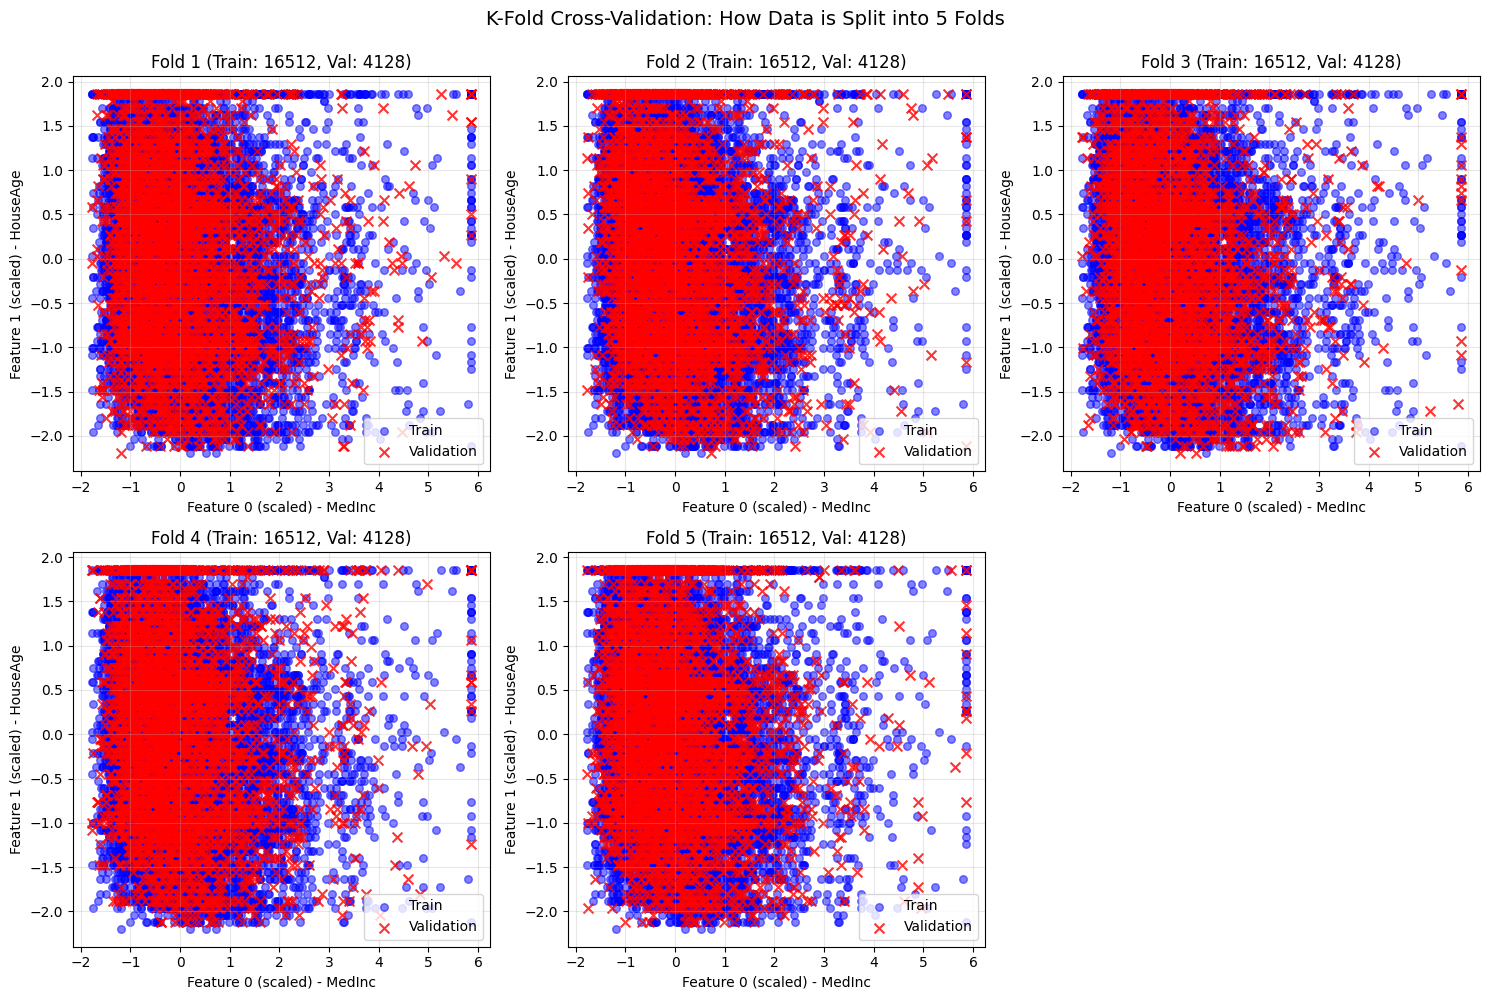

In [96]:
# SOLUTION: Visualize K-Fold splits
# This shows how data is divided into training and validation sets for each fold
# NOTE: We show only 2 features (Feature 0 = MedInc, Feature 1 = HouseAge) for 2D visualization
# The actual dataset has 8 features, but 2D plot helps visualize the concept!

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

kfold_viz = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, val_idx) in enumerate(kfold_viz.split(X_scaled)):
    ax = axes[fold_idx]
    
    # SOLUTION: Plot training data (blue dots)
    # Training data = data used to train the model for this fold (80% of data)
    ax.scatter(X_scaled[train_idx, 0], X_scaled[train_idx, 1],
              alpha=0.5, label='Train', s=30, color='blue')
    
    # SOLUTION: Plot validation data (red X's)
    # Validation data = data used to test the model for this fold (20% of data)
    ax.scatter(X_scaled[val_idx, 0], X_scaled[val_idx, 1],
              alpha=0.8, label='Validation', s=50, marker='x', color='red')
    
    ax.set_title(f'Fold {fold_idx + 1} (Train: {len(train_idx)}, Val: {len(val_idx)})')
    ax.set_xlabel('Feature 0 (scaled) - MedInc')
    ax.set_ylabel('Feature 1 (scaled) - HouseAge')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide the last subplot (we only have 5 folds)
axes[-1].axis('off')
plt.suptitle('K-Fold Cross-Validation: How Data is Split into 5 Folds', 
             fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig('kfold_visualization.png', dpi=300, bbox_inches='tight')

print("\n✅ Plot saved as 'kfold_visualization.png'")
print("\n📊 What This Visualization Shows:")
print("   - Blue dots = Training data for each fold (80% of data)")
print("   - Red X's = Validation data for each fold (20% of data)")
print("   - Each fold uses DIFFERENT data for training/validation!")
print("   - Notice: Each sample appears as validation in ONE fold, training in FOUR folds")

print("\n💡 Key Observations:")
print("   - Fold 1: Different validation set than Fold 2, 3, 4, 5")
print("   - Shuffling ensures each fold has a MIX of all data types")
print("   - All data is used: Each sample tested once, trained 4 times")
print("   - This is why CV is reliable: Tests on different data each time!")

print("\n⚠️  Note: This shows only 2 features (2D projection) for visualization.")
print("   The actual dataset has 8 features, but 2D helps you see the concept!")
print("   - Feature 0 = MedInc (Median Income)")
print("   - Feature 1 = HouseAge (House Age)")
print("   - In reality, we use all 8 features for modeling!")

plt.show()

In [97]:
# 6. Leave-One-Out Cross-Validation (LOOCV)
print("\n" + "=" * 60)
print("6. Leave-One-Out Cross-Validation (LOOCV)")
print("التحقق المتقاطع بإخراج واحد (LOOCV)")
print("=" * 60)
print("\nNote: LOOCV is computationally expensive for large datasets")
print("ملاحظة: LOOCV مكلف حسابياً لمجموعات البيانات الكبيرة")


6. Leave-One-Out Cross-Validation (LOOCV)
التحقق المتقاطع بإخراج واحد (LOOCV)

Note: LOOCV is computationally expensive for large datasets
ملاحظة: LOOCV مكلف حسابياً لمجموعات البيانات الكبيرة


In [98]:
# SOLUTION: Leave-One-Out Cross-Validation (LOOCV)
# LOOCV is expensive for large datasets, so we use a smaller subset for demonstration
# In practice, LOOCV is typically used with datasets < 100 samples

# Use first 30 samples for LOOCV demonstration (faster, still shows the concept)
n_loocv = 30
X_small = X_scaled[:n_loocv]
y_small = y[:n_loocv]

print(f"\n📊 Using {n_loocv} samples for LOOCV demonstration")
print(f"   (LOOCV with all {len(y)} samples would take too long)")

# SOLUTION: Create LeaveOneOut cross-validator
loocv = LeaveOneOut()

# SOLUTION: Perform LOOCV - each fold uses 1 sample for testing, n-1 for training
# IMPORTANT: R² cannot be calculated with single test samples (SS_tot = 0)
# Therefore, we use MSE as the standard metric for LOOCV
loocv_mse_scores = -cross_val_score(LinearRegression(), X_small, y_small,
                                     cv=loocv, scoring='neg_mean_squared_error')

print(f"\n✅ LOOCV Results (n={len(y_small)}):")
print(f"   Each fold: 1 test sample, {len(y_small)-1} training samples")
print(f"   Total folds: {len(y_small)} (one for each sample)")

print(f"\n📊 MSE Results (standard metric for LOOCV):")
print(f"   Mean MSE: {loocv_mse_scores.mean():.4f}")
print(f"   Std MSE: {loocv_mse_scores.std():.4f}")
print(f"   Min MSE: {loocv_mse_scores.min():.4f}")
print(f"   Max MSE: {loocv_mse_scores.max():.4f}")

print(f"\n💡 Why MSE instead of R² for LOOCV?")
print(f"   - R² requires at least 2 samples in test set to calculate variance")
print(f"   - LOOCV test sets have only 1 sample → R² is undefined (SS_tot = 0)")
print(f"   - MSE works perfectly with single predictions → standard for LOOCV")
print(f"   - MSE directly measures prediction error, which is what we want!")

print(f"\n💡 Key Points:")
print(f"   - LOOCV gives the most thorough evaluation (every sample tested)")
print(f"   - Each model is trained on n-1 samples and tested on 1 sample")
print(f"   - Very reliable but slow (n model trainings required)")
print(f"   - Best for small datasets where you need maximum data usage!")
print(f"   - MSE is the standard metric for LOOCV (R² not applicable)")

# SOLUTION: Compare LOOCV with K-Fold for the same subset
print(f"\n📊 Comparison: LOOCV vs 5-Fold CV (on same {n_loocv} samples):")
kfold_small = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_scores = -cross_val_score(LinearRegression(), X_small, y_small,
                                cv=kfold_small, scoring='neg_mean_squared_error')
print(f"   LOOCV Mean MSE: {loocv_mse_scores.mean():.4f}")
print(f"   5-Fold Mean MSE: {kfold_scores.mean():.4f}")
print(f"   Difference: {abs(loocv_mse_scores.mean() - kfold_scores.mean()):.4f}")
print(f"   💡 Both methods give similar results, but LOOCV is more thorough!")


📊 Using 30 samples for LOOCV demonstration
   (LOOCV with all 20640 samples would take too long)

✅ LOOCV Results (n=30):
   Each fold: 1 test sample, 29 training samples
   Total folds: 30 (one for each sample)

📊 MSE Results (standard metric for LOOCV):
   Mean MSE: 0.3040
   Std MSE: 0.6278
   Min MSE: 0.0002
   Max MSE: 3.5534

💡 Why MSE instead of R² for LOOCV?
   - R² requires at least 2 samples in test set to calculate variance
   - LOOCV test sets have only 1 sample → R² is undefined (SS_tot = 0)
   - MSE works perfectly with single predictions → standard for LOOCV
   - MSE directly measures prediction error, which is what we want!

💡 Key Points:
   - LOOCV gives the most thorough evaluation (every sample tested)
   - Each model is trained on n-1 samples and tested on 1 sample
   - Very reliable but slow (n model trainings required)
   - Best for small datasets where you need maximum data usage!
   - MSE is the standard metric for LOOCV (R² not applicable)

📊 Comparison: LOOCV

In [99]:
# 7. Cross-Validation Score Distribution
print("\n" + "=" * 60)
print("7. Cross-Validation Score Distribution")
print("توزيع نتائج التحقق المتقاطع")
print("=" * 60)


7. Cross-Validation Score Distribution
توزيع نتائج التحقق المتقاطع


In [100]:
# SOLUTION: Get scores for all folds
# This collects R² scores from each fold for visualization
# We'll use these scores to create a bar chart showing score distribution

all_scores = []
for train_idx, val_idx in kfold.split(X_scaled):
    model_temp = LinearRegression()
    model_temp.fit(X_scaled[train_idx], y[train_idx])
    pred = model_temp.predict(X_scaled[val_idx])
    score = r2_score(y[val_idx], pred)
    all_scores.append(score)

print(f"\n📊 Scores collected from {len(all_scores)} folds:")
for i, score in enumerate(all_scores, 1):
    print(f"   Fold {i}: R² = {score:.4f}")
print(f"\n   Mean R²: {np.mean(all_scores):.4f}")
print(f"   Std R²: {np.std(all_scores):.4f}")
print(f"   Range: [{min(all_scores):.4f}, {max(all_scores):.4f}]")


📊 Scores collected from 5 folds:
   Fold 1: R² = 0.5758
   Fold 2: R² = 0.6137
   Fold 3: R² = 0.6086
   Fold 4: R² = 0.6213
   Fold 5: R² = 0.5875

   Mean R²: 0.6014
   Std R²: 0.0170
   Range: [0.5758, 0.6213]


## 📊 Why Visualize Score Distribution? | لماذا تصور توزيع النتائج؟

**BEFORE**: You've seen the scores for each fold, but haven't visualized the distribution.

**AFTER**: You'll see visually how consistent (or variable) model performance is across folds!

**Why visualize?**
- **See variation**: Visual representation of how much scores vary
- **Understand consistency**: See if model performance is stable or variable
- **Compare models**: Visual comparison is easier than numbers
- **Build intuition**: Visual learning helps understand variance

**What you'll learn:**
- How to interpret score variation visually
- What "consistent" vs "variable" performance looks like
- How to use mean ± std for model evaluation
- When to be concerned about high variation

**What to look for:**
- **Good**: Bars close together, small shaded area → consistent performance ✅
- **Concerning**: Bars far apart, large shaded area → variable performance ⚠️
- **Mean line**: Average performance across all folds
- **Shaded area**: ±1 standard deviation (68% of scores fall here)


## Step 8: Decision Framework - When to Use Each Cross-Validation Method | الخطوة 8: إطار القرار - متى تستخدم كل طريقة تحقق متقاطع

**BEFORE**: You've learned different cross-validation methods, but when should you use each one?

**AFTER**: You'll have a clear decision framework to choose the right cross-validation method for any situation!

**Why this matters**: Using the wrong cross-validation method can:
- **Unreliable evaluation** → Wrong method gives biased estimates
- **Wasted computation** → Using expensive methods when simple ones work
- **Poor model selection** → Wrong evaluation leads to wrong model choice

---

### 🎯 Decision Framework: Which Cross-Validation Method? | إطار القرار: أي طريقة تحقق متقاطع؟

**Key Question**: Should I use **K-FOLD**, **STRATIFIED K-FOLD**, **LEAVE-ONE-OUT**, or **SIMPLE TRAIN-TEST SPLIT**?

#### Decision Tree:

```
What type of problem do you have?
├─ CLASSIFICATION → Check class balance
│   ├─ Balanced classes → Use STRATIFIED K-FOLD ✅
│   │   └─ Why? Maintains class distribution in each fold
│   │
│   └─ Imbalanced classes → Use STRATIFIED K-FOLD ✅
│       └─ Why? Critical for imbalanced data
│
└─ REGRESSION → Check dataset size
    ├─ Small dataset (< 100 samples) → Use LEAVE-ONE-OUT ✅
    │   └─ Why? Maximum data usage, most reliable
    │
    ├─ Medium dataset (100-10,000) → Use K-FOLD (K=5 or 10) ✅
    │   └─ Why? Good balance of reliability and speed
    │
    └─ Large dataset (> 10,000) → Use SIMPLE TRAIN-TEST SPLIT or K-FOLD (K=5) ✅
        └─ Why? Large datasets, simple split is often sufficient
```

#### Detailed Decision Process:

```
Step 1: Problem Type
├─ Classification → Go to Step 2
└─ Regression → Go to Step 3

Step 2: Classification - Check Class Balance
├─ Balanced classes (similar counts) → Use STRATIFIED K-FOLD (K=5 or 10)
│   └─ Why? Maintains class distribution
│
└─ Imbalanced classes (very different counts) → Use STRATIFIED K-FOLD (K=5 or 10)
    └─ Why? Critical to maintain distribution in imbalanced data

Step 3: Regression - Check Dataset Size
├─ Very small (< 50 samples) → Use LEAVE-ONE-OUT (LOOCV)
│   └─ Why? Maximum data usage, most reliable for small data
│
├─ Small (50-100 samples) → Use K-FOLD (K=10) or LEAVE-ONE-OUT
│   └─ Why? Need more folds for reliable estimate
│
├─ Medium (100-10,000 samples) → Use K-FOLD (K=5 or 10)
│   └─ Why? Standard choice, good balance
│
└─ Large (> 10,000 samples) → Use SIMPLE TRAIN-TEST SPLIT or K-FOLD (K=5)
    └─ Why? Large datasets, simple split often sufficient
```

---

### 📊 Comparison Table: Cross-Validation Methods | جدول المقارنة

| Method | When to Use | Pros | Cons | Example |
|--------|-------------|------|------|---------|
| **Simple Train-Test Split** | Large datasets, quick evaluation | • Fast<br>• Simple<br>• One evaluation | • Less reliable<br>• Single split may be lucky/unlucky<br>• Doesn't use all data | Dataset with 50,000+ samples |
| **K-Fold (K=5)** | Medium datasets, standard choice | • Reliable<br>• Uses all data<br>• Good balance | • 5 evaluations (slower)<br>• May not maintain class distribution | Dataset with 1,000-10,000 samples |
| **K-Fold (K=10)** | Small-medium datasets, more reliable | • Very reliable<br>• Uses all data<br>• More folds = better estimate | • 10 evaluations (slower)<br>• More computation | Dataset with 100-5,000 samples |
| **Stratified K-Fold** | Classification problems (any size) | • Maintains class distribution<br>• Reliable for classification<br>• Works with imbalanced data | • Only for classification<br>• Slightly more complex | Any classification problem |
| **Leave-One-Out (LOOCV)** | Very small datasets | • Maximum data usage<br>• Most reliable for small data<br>• Unbiased estimate | • Very slow (n evaluations)<br>• High variance<br>• Expensive | Dataset with < 50 samples |

---

### ✅ When to Use Each Method | متى تستخدم كل طريقة

#### Use Simple Train-Test Split when:
1. **Large Dataset** ✅
   - More than 10,000 samples
   - Single split is reliable enough
   - **Example**: 50,000+ samples, quick evaluation needed

2. **Quick Evaluation** ✅
   - Need fast results
   - Don't need maximum reliability
   - **Example**: Initial model testing, baseline evaluation

3. **Computational Constraints** ✅
   - Very expensive models (deep learning)
   - Can't afford multiple evaluations
   - **Example**: Training neural networks

#### Use K-Fold (K=5) when:
1. **Medium Dataset** ✅
   - 1,000-10,000 samples
   - Standard choice for most problems
   - **Example**: Most regression problems

2. **Balanced Reliability/Speed** ✅
   - Need reliable evaluation
   - Don't want too slow
   - **Example**: Model comparison, hyperparameter tuning

#### Use K-Fold (K=10) when:
1. **Small-Medium Dataset** ✅
   - 100-5,000 samples
   - Need more reliable estimate
   - **Example**: Limited data, need best estimate

2. **Model Selection** ✅
   - Comparing multiple models
   - Need reliable comparison
   - **Example**: Choosing between different algorithms

#### Use Stratified K-Fold when:
1. **Classification Problem** ✅
   - Any classification task
   - Maintains class distribution
   - **Example**: Binary or multiclass classification

2. **Imbalanced Classes** ✅
   - Classes have very different counts
   - Critical to maintain distribution
   - **Example**: Fraud detection (99% normal, 1% fraud)

3. **Small Classification Dataset** ✅
   - Small dataset with classes
   - Need to maintain distribution
   - **Example**: Medical diagnosis with limited data

#### Use Leave-One-Out (LOOCV) when:
1. **Very Small Dataset** ✅
   - Less than 50 samples
   - Need maximum data usage
   - **Example**: Rare disease study with 30 patients

2. **Maximum Reliability Needed** ✅
   - Small dataset, need best estimate
   - Can afford computation time
   - **Example**: Expensive data collection, need best evaluation

---

### ❌ When NOT to Use Each Method | متى لا تستخدم كل طريقة

#### Don't use Simple Train-Test Split when:
1. **Small Dataset** ❌
   - Less than 1,000 samples
   - Single split unreliable
   - **Use Instead**: K-Fold or LOOCV

2. **Model Selection** ❌
   - Comparing multiple models
   - Need reliable comparison
   - **Use Instead**: K-Fold Cross-Validation

#### Don't use K-Fold when:
1. **Very Small Dataset** ❌
   - Less than 50 samples
   - K folds may have too few samples per fold
   - **Use Instead**: Leave-One-Out (LOOCV)

2. **Imbalanced Classification** ❌
   - Classes very imbalanced
   - K-Fold may not maintain distribution
   - **Use Instead**: Stratified K-Fold

#### Don't use Stratified K-Fold when:
1. **Regression Problem** ❌
   - Predicting continuous values
   - No classes to stratify
   - **Use Instead**: Regular K-Fold

#### Don't use Leave-One-Out when:
1. **Large Dataset** ❌
   - More than 100 samples
   - Too slow, high variance
   - **Use Instead**: K-Fold (K=5 or 10)

2. **Computational Constraints** ❌
   - Expensive models
   - Can't afford n evaluations
   - **Use Instead**: K-Fold (K=5)

---

### 📊 Real-World Examples | أمثلة من العالم الحقيقي

#### Example 1: House Price Prediction (5,000 samples) ✅ K-FOLD (K=5)
- **Problem**: Regression (predicting price)
- **Dataset Size**: 5,000 samples (medium)
- **Decision**: ✅ Use K-Fold (K=5)
- **Reasoning**: Medium dataset, regression problem, standard choice

#### Example 2: Customer Churn Prediction (10,000 samples, imbalanced) ✅ STRATIFIED K-FOLD
- **Problem**: Classification (churn/not churn)
- **Dataset Size**: 10,000 samples
- **Class Balance**: Imbalanced (95% not churn, 5% churn)
- **Decision**: ✅ Use Stratified K-Fold (K=5)
- **Reasoning**: Classification, imbalanced classes, need to maintain distribution

#### Example 3: Rare Disease Diagnosis (30 samples) ✅ LEAVE-ONE-OUT
- **Problem**: Classification (disease/healthy)
- **Dataset Size**: 30 samples (very small)
- **Decision**: ✅ Use Leave-One-Out (LOOCV)
- **Reasoning**: Very small dataset, need maximum data usage, can afford computation

#### Example 4: Image Classification (100,000 samples) ✅ SIMPLE SPLIT or K-FOLD (K=5)
- **Problem**: Classification (10 classes)
- **Dataset Size**: 100,000 samples (large)
- **Decision**: ✅ Use Simple Train-Test Split or K-Fold (K=5)
- **Reasoning**: Large dataset, simple split often sufficient, or K=5 for more reliability

---

### ✅ Key Takeaways | النقاط الرئيسية

1. **Classification → Stratified K-Fold** - Always use stratified for classification
2. **Small data → More folds** - Use K=10 or LOOCV for small datasets
3. **Large data → Simple split** - Simple split often sufficient for large datasets
4. **Standard choice → K=5** - Good default for most problems
5. **Imbalanced → Stratified** - Critical for imbalanced classification
6. **Model selection → K-Fold** - Use K-Fold for comparing models
7. **Balance reliability/speed** - Choose method based on dataset size and needs

---

### 🎓 Practice Decision-Making | ممارسة اتخاذ القرار

**Scenario 1**: Predicting house prices with 8,000 samples
- **Problem**: Regression
- **Dataset Size**: 8,000 (medium)
- **Decision**: ✅ K-Fold (K=5) - standard choice for medium regression

**Scenario 2**: Predicting customer churn with 2,000 samples (imbalanced: 90% not churn)
- **Problem**: Classification
- **Dataset Size**: 2,000 (medium)
- **Class Balance**: Imbalanced
- **Decision**: ✅ Stratified K-Fold (K=5) - classification with imbalanced classes

**Scenario 3**: Medical diagnosis with 25 patients
- **Problem**: Classification
- **Dataset Size**: 25 (very small)
- **Decision**: ✅ Leave-One-Out (LOOCV) - very small dataset, need maximum data usage

**Scenario 4**: Image classification with 200,000 images
- **Problem**: Classification
- **Dataset Size**: 200,000 (very large)
- **Decision**: ✅ Simple Train-Test Split or K-Fold (K=5) - large dataset, simple split sufficient

---

**Connection to Next Steps**: 
- 📓 **Unit 5, Example 1: Grid Search** - Uses cross-validation for hyperparameter tuning
- 📓 **Unit 3: Classification** - Stratified K-Fold for all classification problems
- 📓 **All ML Projects** - Cross-validation is the gold standard for evaluation



✅ Plot saved as 'cv_score_distribution.png'

📊 What This Visualization Shows:
   - Each bar = R² score for one fold (height = performance)
   - Red dashed line = Mean R² across all folds (average performance)
   - Red shaded area = ±1 standard deviation (68% confidence interval)
   - Value labels = Exact R² score for each fold

💡 How to Interpret This Plot:
   - Mean R²: 0.6014 (average performance)
   - Std: 0.0170 (variation across folds)
   - Range: [0.5758, 0.6213] (min to max)

   Consistency: ✅ Very consistent
   Model performance is very stable across folds - reliable model!

📈 What to Look For:
   - Bars close together → Consistent performance (good!)
   - Bars far apart → Variable performance (investigate!)
   - Mean line in middle → Balanced performance
   - Small shaded area → Low variance (reliable!)
   - Large shaded area → High variance (less reliable)

🎯 How to Use This:
   - Compare different models: Lower std = more reliable
   - Check consistency: Small range = stabl

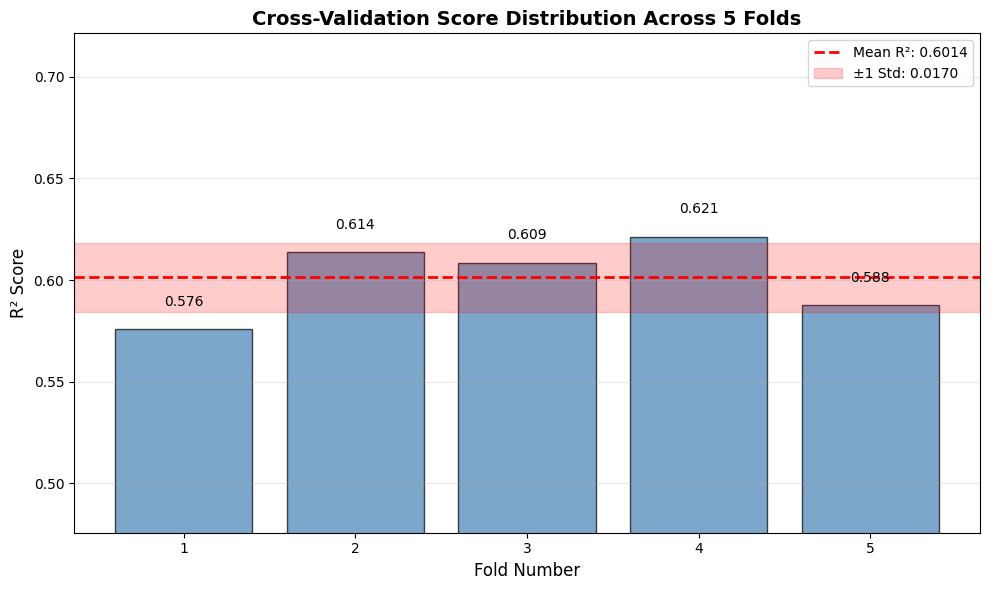


📚 Summary: What You Learned | الملخص: ما تعلمته

✅ Complete Solutions Provided:
   1. ✅ Simple train-test split (baseline comparison)
   2. ✅ K-Fold cross-validation (5-fold)
   3. ✅ Manual cross-validation implementation (step-by-step)
   4. ✅ Multiple metrics with cross_validate()
   5. ✅ Model comparison using cross-validation
   6. ✅ K-Fold visualization (how data is split)
   7. ✅ Leave-One-Out CV (LOOCV) for small datasets
   8. ✅ Score distribution visualization

💡 Key Takeaways:
   - Cross-validation gives more reliable evaluation than single split
   - K-Fold (K=5) is the standard choice for most problems
   - LOOCV is best for very small datasets (< 50 samples)
   - Cross-validation enables fair model comparison
   - All solutions are complete and runnable!

Example 2 Complete! ✓
اكتمل المثال 2! ✓


In [101]:
# SOLUTION: Visualize score distribution across folds
# This bar chart shows how R² scores vary across the 5 folds
# Helps us understand if model performance is consistent or variable

plt.figure(figsize=(10, 6))

# SOLUTION: Create bar chart showing R² score for each fold
# Each bar represents the R² score from one fold (height = performance)
bars = plt.bar(range(1, len(all_scores) + 1), all_scores, 
               alpha=0.7, edgecolor='black', color='steelblue')

# SOLUTION: Add mean line
# Red dashed line shows the average R² across all folds
mean_score = np.mean(all_scores)
plt.axhline(mean_score, color='r', linestyle='--', linewidth=2,
           label=f'Mean R²: {mean_score:.4f}')

# SOLUTION: Add standard deviation bands
# Red shaded area shows ±1 standard deviation (68% of scores fall here)
std_score = np.std(all_scores)
plt.axhspan(mean_score - std_score, mean_score + std_score, 
           alpha=0.2, color='red', label=f'±1 Std: {std_score:.4f}')

# SOLUTION: Add value labels on bars
# Shows exact R² value for each fold
for i, (bar, score) in enumerate(zip(bars, all_scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{score:.3f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Cross-Validation Score Distribution Across 5 Folds', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([min(all_scores) - 0.1, max(all_scores) + 0.1])
plt.xticks(range(1, len(all_scores) + 1))
plt.tight_layout()
plt.savefig('cv_score_distribution.png', dpi=300, bbox_inches='tight')
print("\n✅ Plot saved as 'cv_score_distribution.png'")
print("\n📊 What This Visualization Shows:")
print("   - Each bar = R² score for one fold (height = performance)")
print("   - Red dashed line = Mean R² across all folds (average performance)")
print("   - Red shaded area = ±1 standard deviation (68% confidence interval)")
print("   - Value labels = Exact R² score for each fold")

print("\n💡 How to Interpret This Plot:")
mean_score = np.mean(all_scores)
std_score = np.std(all_scores)
print(f"   - Mean R²: {mean_score:.4f} (average performance)")
print(f"   - Std: {std_score:.4f} (variation across folds)")
print(f"   - Range: [{min(all_scores):.4f}, {max(all_scores):.4f}] (min to max)")

# Automatic interpretation based on standard deviation
if std_score < 0.05:
    consistency = "✅ Very consistent"
    interpretation = "Model performance is very stable across folds - reliable model!"
elif std_score < 0.1:
    consistency = "✅ Consistent"
    interpretation = "Model performance is fairly stable - good model!"
else:
    consistency = "⚠️  Variable"
    interpretation = "Model performance varies across folds - may need investigation!"

print(f"\n   Consistency: {consistency}")
print(f"   {interpretation}")

print("\n📈 What to Look For:")
print("   - Bars close together → Consistent performance (good!)")
print("   - Bars far apart → Variable performance (investigate!)")
print("   - Mean line in middle → Balanced performance")
print("   - Small shaded area → Low variance (reliable!)")
print("   - Large shaded area → High variance (less reliable)")

print("\n🎯 How to Use This:")
print("   - Compare different models: Lower std = more reliable")
print("   - Check consistency: Small range = stable model")
print("   - Confidence interval: Mean ± Std shows performance range")
print("   - Model selection: Choose models with consistent performance!")

plt.show()

print("\n" + "=" * 60)
print("📚 Summary: What You Learned | الملخص: ما تعلمته")
print("=" * 60)
print("\n✅ Complete Solutions Provided:")
print("   1. ✅ Simple train-test split (baseline comparison)")
print("   2. ✅ K-Fold cross-validation (5-fold)")
print("   3. ✅ Manual cross-validation implementation (step-by-step)")
print("   4. ✅ Multiple metrics with cross_validate()")
print("   5. ✅ Model comparison using cross-validation")
print("   6. ✅ K-Fold visualization (how data is split)")
print("   7. ✅ Leave-One-Out CV (LOOCV) for small datasets")
print("   8. ✅ Score distribution visualization")
print("\n💡 Key Takeaways:")
print("   - Cross-validation gives more reliable evaluation than single split")
print("   - K-Fold (K=5) is the standard choice for most problems")
print("   - LOOCV is best for very small datasets (< 50 samples)")
print("   - Cross-validation enables fair model comparison")
print("   - All solutions are complete and runnable!")
print("\n" + "=" * 60)
print("Example 2 Complete! ✓")
print("اكتمل المثال 2! ✓")
print("=" * 60)